In [1]:
import numpy as np
from typing import List, Optional, Union, Iterable
import matplotlib.pyplot as plt 
from tqdm import tqdm

np.random.seed(42)


In [2]:
class Bandit:
    """
    A Multi-Armed Bandit model supporting:
        - Gaussian Bandit (normally distributed arms)
        - Bernoulli Bandit (Bernoulli-distributed arms)
        - Reward-gap Bandit (introducing a structured reward difference)
    """

    def __init__(self, K: int, dist_type: str, means: Optional[Iterable[float]] = None, 
                 delta: Optional[float] = None):
        """
        Initializes the Bandit.

        Args:
            K (int): Number of arms.
            dist_type (str): Either 'gaussian' or 'bernoulli'.
            means (Optional[Iterable[float]]): User-defined means (or probabilities for Bernoulli).
            delta (Optional[float]): The reward gap Δ for 'reward-gap' mode.
        """
        if dist_type not in {'gaussian', 'bernoulli'}:
            raise ValueError(f"Invalid dist_type '{dist_type}'. Expected 'gaussian' or 'bernoulli'.")

        self.dist_type = dist_type
        self.K = K

        if means is not None:
            self._validate_means(means)
            self.means = list(means) if self.dist_type == 'gaussian' else None
            self.p = list(means) if self.dist_type == 'bernoulli' else None
        elif delta is not None:
            if delta <= 0:
                raise ValueError("Reward gap mode requires a positive delta value.")
            self.delta = delta
            self._initialize_reward_gap()
        else:
            self._random_init()


    def _validate_means(self, means: Iterable[float]) -> None:
        """Ensures the provided means/probabilities are valid."""
        if not isinstance(means, (list, np.ndarray)):
            raise TypeError("Means must be a list or a numpy array.")
        if len(means) != self.K:
            raise ValueError(f"For K={self.K} arms, {len(means)} values provided.")


    def _random_init(self) -> None:
        """Randomly initializes means for Gaussian bandits and probabilities for Bernoulli bandits."""
        if self.dist_type == 'gaussian':
            self.means = np.random.normal(0, 1, self.K).tolist()
        elif self.dist_type == 'bernoulli':
            self.p = np.random.uniform(0, 1, self.K).tolist()


    def _initialize_reward_gap(self) -> None:
        """Applies the reward-gap modification."""
        if self.dist_type == 'gaussian':
            base_means = np.random.normal(0, 1, self.K).tolist()
            mu_star = max(base_means)
            self.means = [mu_star - k * self.delta for k in range(self.K)]

        elif self.dist_type == 'bernoulli':
            base_p = np.random.uniform(0, 1, self.K).tolist()
            p_star = max(base_p)
            self.p = [max(p_star - k * self.delta, 0) for k in range(self.K)]

    def perform_action(self, i: int) -> float:
        """
        Simulates pulling arm i.

        Args:
            i (int): The index of the arm to pull.

        Returns:
            float: The reward obtained.
        """
        if not (0 <= i < self.K):
            raise IndexError(f"Invalid arm index {i}. Must be in range [0, {self.K-1}].")

        if self.dist_type == 'gaussian':
            return np.random.normal(self.means[i], 1)
        elif self.dist_type == 'bernoulli':
            return np.random.binomial(1, self.p[i])

        raise RuntimeError("Invalid mode. This should never happen.")

    def __repr__(self) -> str:
        """Returns a readable string representation of the Bandit model."""
        if self.dist_type == 'gaussian':
            means_str = ", ".join(f"{m:.2f}" for m in self.means)
            return f"Bandit(dist_type='gaussian', K={self.K}, means=[{means_str}])"
        elif self.dist_type == 'bernoulli':
            p_str = ", ".join(f"{p:.2f}" for p in self.p)
            return f"Bandit(dist_type='bernoulli', K={self.K}, p=[{p_str}])"
        return "Bandit(dist_type='unknown')"


In [3]:
import numpy as np
from abc import ABC, abstractmethod

class BanditAgent(ABC):
    def __init__(self, K: int):
        self.K = K
        self.counts = np.zeros(K)  # Number of times each arm is pulled
        self.values = np.zeros(K)  # Estimated mean reward for each arm

    @abstractmethod
    def select_arm(self) -> int:
        pass

    def update(self, chosen_arm: int, reward: float) -> None:
        """Updates estimates with new reward."""
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        self.values[chosen_arm] += (reward - self.values[chosen_arm]) / n


In [4]:
class EpsilonGreedyAgent(BanditAgent):
    def __init__(self, K: int, epsilon: float):
        super().__init__(K)
        self.epsilon = epsilon

    def select_arm(self) -> int:
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.K)
        else:
            return np.argmax(self.values)


In [5]:
def simulate(bandit, agent, horizon: int) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Simulates interaction between bandit and agent.

    Returns:
        rewards: Array of obtained rewards.
        regret: Array of cumulative regret.
        optimal_choices: Binary array indicating if optimal arm was chosen.
    """
    rewards = np.zeros(horizon)
    regret = np.zeros(horizon)
    optimal_choices = np.zeros(horizon)
    optimal_arm = np.argmax(bandit.means)
    optimal_mean = bandit.means[optimal_arm]

    for t in range(horizon):
        arm = agent.select_arm()
        reward = bandit.perform_action(arm)
        agent.update(arm, reward)

        rewards[t] = reward
        regret[t] = (optimal_mean - bandit.means[arm]) if bandit.dist_type == 'gaussian' else 0.0
        optimal_choices[t] = 1 if arm == optimal_arm else 0

        if t > 0:
            regret[t] += regret[t - 1]  # Cumulative regret

    return rewards, regret, optimal_choices


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # For progress bars

# Setup
K = 10
horizon = 10000
num_simulations = 50
epsilons = [0.01, 0.05, 0.1, 0.2]

all_results = {eps: {'regret': [], 'optimal': []} for eps in epsilons}

# Run experiments
for eps in epsilons:
    print(f"Running simulations for epsilon = {eps}")
    for _ in tqdm(range(num_simulations)):
        bandit = Bandit(K=K, dist_type='gaussian')
        agent = EpsilonGreedyAgent(K=K, epsilon=eps)
        _, regret, optimal_choices = simulate(bandit, agent, horizon)
        all_results[eps]['regret'].append(regret)
        all_results[eps]['optimal'].append(optimal_choices)


Running simulations for epsilon = 0.01


100%|██████████| 50/50 [00:01<00:00, 41.76it/s]


Running simulations for epsilon = 0.05


100%|██████████| 50/50 [00:01<00:00, 41.96it/s]


Running simulations for epsilon = 0.1


100%|██████████| 50/50 [00:01<00:00, 43.12it/s]


Running simulations for epsilon = 0.2


100%|██████████| 50/50 [00:01<00:00, 40.41it/s]


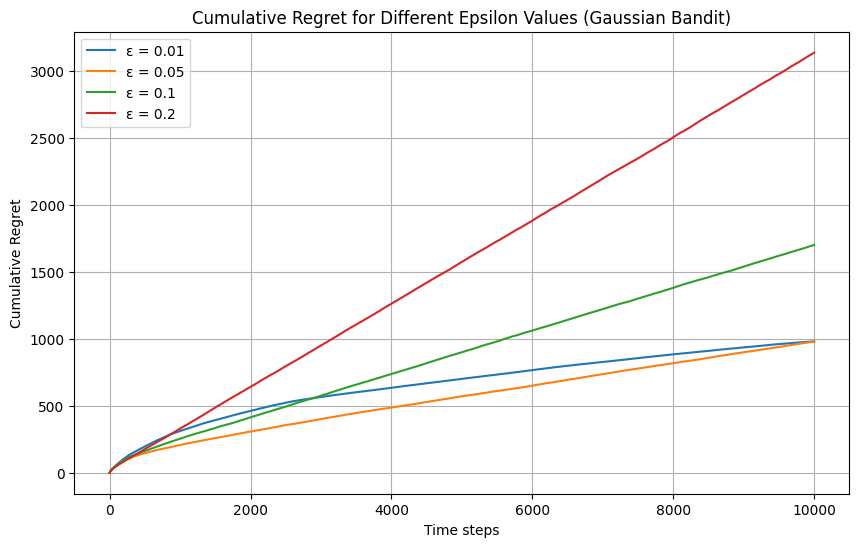

In [7]:
plt.figure(figsize=(10, 6))
for eps in epsilons:
    mean_regret = np.mean(all_results[eps]['regret'], axis=0)
    plt.plot(mean_regret, label=f"ε = {eps}")

plt.xlabel("Time steps")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret for Different Epsilon Values (Gaussian Bandit)")
plt.legend()
plt.grid()
plt.show()


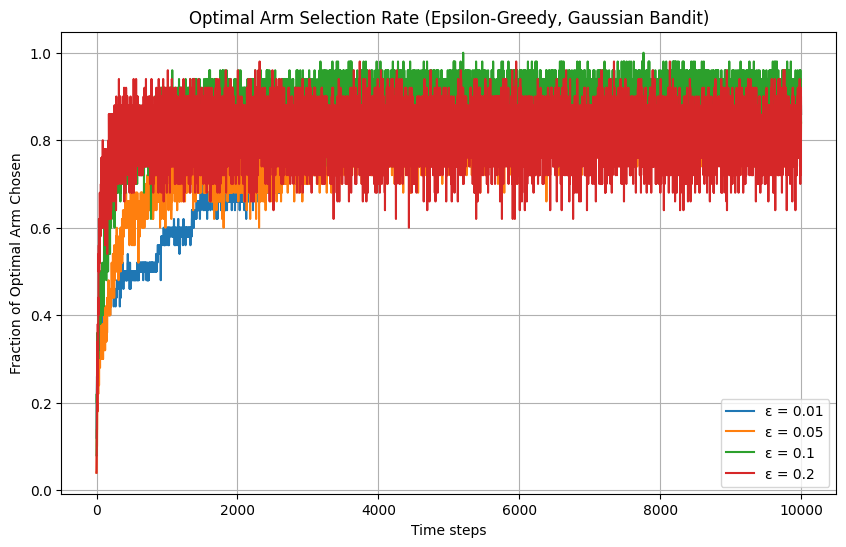

In [8]:
plt.figure(figsize=(10, 6))
for eps in epsilons:
    mean_optimal = np.mean(all_results[eps]['optimal'], axis=0)
    plt.plot(mean_optimal, label=f"ε = {eps}")

plt.xlabel("Time steps")
plt.ylabel("Fraction of Optimal Arm Chosen")
plt.title("Optimal Arm Selection Rate (Epsilon-Greedy, Gaussian Bandit)")
plt.legend()
plt.grid()
plt.show()


In [9]:
def track_value_estimates(bandit, agent, horizon: int):
    value_history = np.zeros((horizon, bandit.K))
    for t in range(horizon):
        arm = agent.select_arm()
        reward = bandit.perform_action(arm)
        agent.update(arm, reward)
        value_history[t] = agent.values
    return value_history


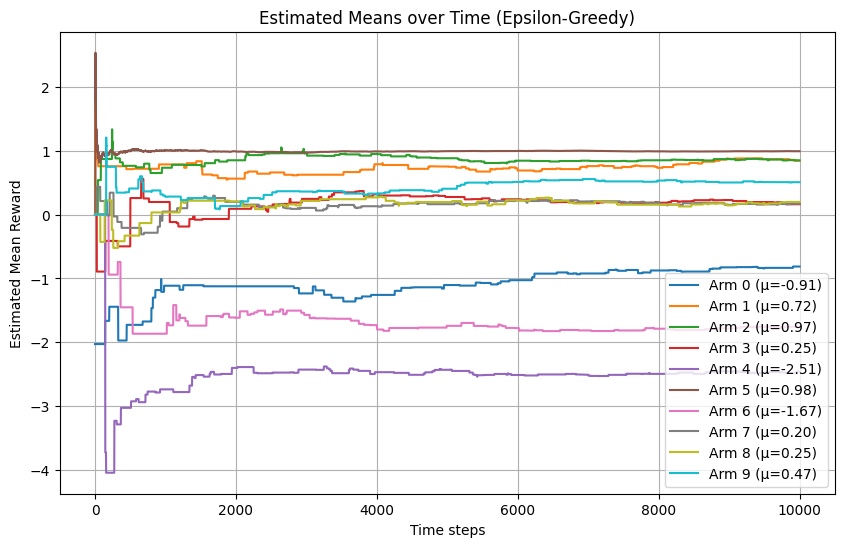

In [10]:
bandit = Bandit(K=K, dist_type='gaussian')
agent = EpsilonGreedyAgent(K=K, epsilon=0.1)
values = track_value_estimates(bandit, agent, horizon)

plt.figure(figsize=(10, 6))
for k in range(K):
    plt.plot(values[:, k], label=f"Arm {k} (μ={bandit.means[k]:.2f})")

plt.xlabel("Time steps")
plt.ylabel("Estimated Mean Reward")
plt.title("Estimated Means over Time (Epsilon-Greedy)")
plt.legend()
plt.grid()
plt.show()


## UCB

In [11]:
class UCBAgent(BanditAgent):
    def __init__(self, K: int):
        super().__init__(K)
        self.total_count = 0  # To keep track of total time steps

    def select_arm(self) -> int:
        self.total_count += 1
        # Ensure all arms are pulled at least once
        for arm in range(self.K):
            if self.counts[arm] == 0:
                return arm

        # Compute UCB for all arms
        ucb_values = self.values + np.sqrt(2 * np.log(self.total_count) / self.counts)
        return np.argmax(ucb_values)


In [12]:
ucb_results = {'regret': [], 'optimal': []}

print("Running simulations for UCB")
for _ in tqdm(range(num_simulations)):
    bandit = Bandit(K=K, dist_type='gaussian')
    agent = UCBAgent(K=K)
    _, regret, optimal_choices = simulate(bandit, agent, horizon)
    ucb_results['regret'].append(regret)
    ucb_results['optimal'].append(optimal_choices)


Running simulations for UCB


100%|██████████| 50/50 [00:02<00:00, 23.23it/s]


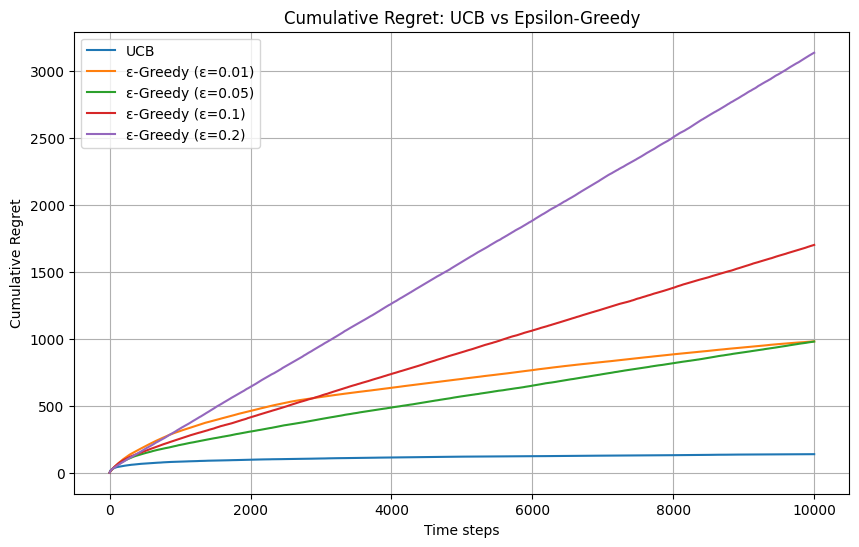

In [13]:
plt.figure(figsize=(10, 6))

# Plot UCB
mean_ucb_regret = np.mean(ucb_results['regret'], axis=0)
plt.plot(mean_ucb_regret, label="UCB")

# Plot epsilon-greedy with multiple epsilons
for eps in epsilons:
    mean_regret = np.mean(all_results[eps]['regret'], axis=0)
    plt.plot(mean_regret, label=f"ε-Greedy (ε={eps})")

plt.xlabel("Time steps")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret: UCB vs Epsilon-Greedy")
plt.legend()
plt.grid()
plt.show()


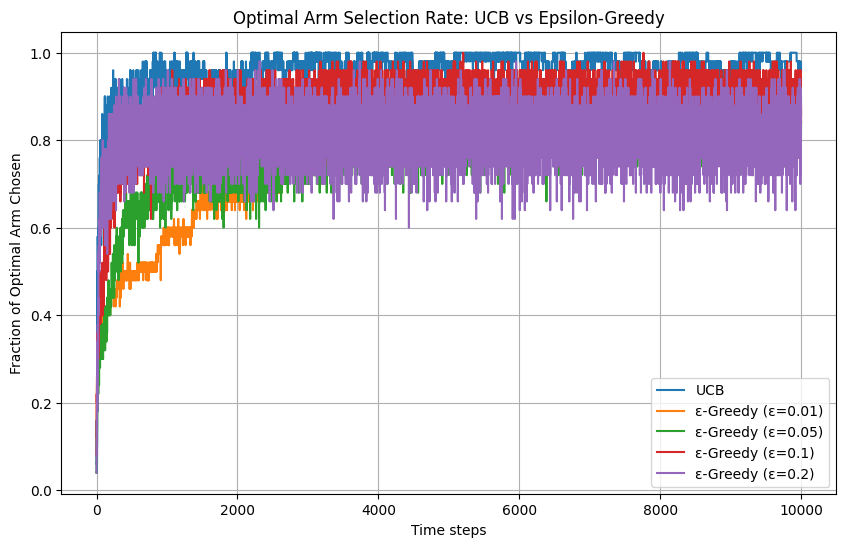

In [14]:
plt.figure(figsize=(10, 6))

# Plot UCB
mean_ucb_optimal = np.mean(ucb_results['optimal'], axis=0)
plt.plot(mean_ucb_optimal, label="UCB")

# Plot epsilon-greedy
for eps in epsilons:
    mean_optimal = np.mean(all_results[eps]['optimal'], axis=0)
    plt.plot(mean_optimal, label=f"ε-Greedy (ε={eps})")

plt.xlabel("Time steps")
plt.ylabel("Fraction of Optimal Arm Chosen")
plt.title("Optimal Arm Selection Rate: UCB vs Epsilon-Greedy")
plt.legend()
plt.grid()
plt.show()


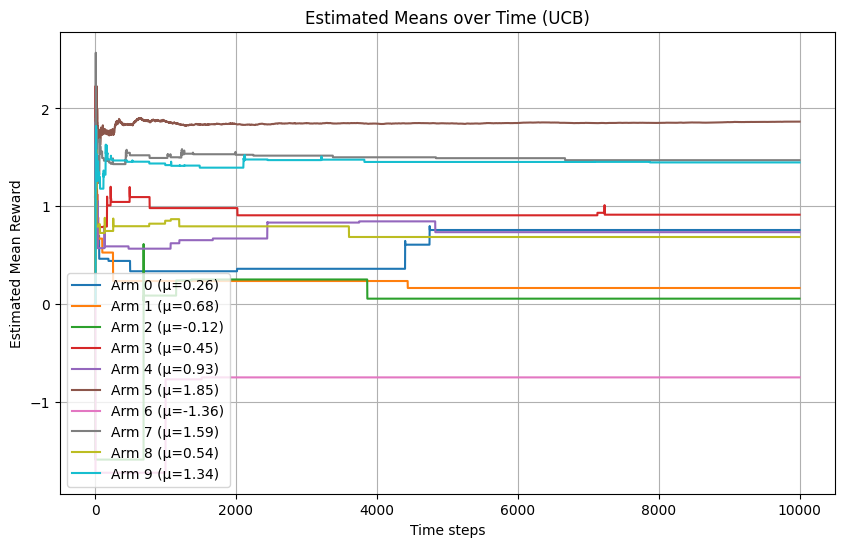

In [15]:
bandit = Bandit(K=K, dist_type='gaussian')
agent = UCBAgent(K=K)
values = track_value_estimates(bandit, agent, horizon)

plt.figure(figsize=(10, 6))
for k in range(K):
    plt.plot(values[:, k], label=f"Arm {k} (μ={bandit.means[k]:.2f})")

plt.xlabel("Time steps")
plt.ylabel("Estimated Mean Reward")
plt.title("Estimated Means over Time (UCB)")
plt.legend()
plt.grid()
plt.show()


## ETC

In [16]:
class ETCAgent(BanditAgent):
    def __init__(self, K: int, m: int, horizon: int):
        super().__init__(K)
        self.m = m
        self.horizon = horizon
        self.total_count = 0
        self.best_arm = None
        self.exploration_done = False

    def select_arm(self) -> int:
        self.total_count += 1

        if not self.exploration_done:
            # Explore each arm m times
            arm = (self.total_count - 1) % self.K
            if self.total_count == self.K * self.m:
                self.exploration_done = True
                self.best_arm = np.argmax(self.values)  # Choose the best estimated arm
            return arm
        else:
            # Commit to the best arm
            return self.best_arm


In [17]:
m_values = [5, 10, 20]  # Different m to explore

etc_results = {m: {'regret': [], 'optimal': []} for m in m_values}

for m in m_values:
    print(f"Running simulations for ETC (m = {m})")
    for _ in tqdm(range(num_simulations)):
        bandit = Bandit(K=K, dist_type='gaussian')
        agent = ETCAgent(K=K, m=m, horizon=horizon)
        _, regret, optimal_choices = simulate(bandit, agent, horizon)
        etc_results[m]['regret'].append(regret)
        etc_results[m]['optimal'].append(optimal_choices)


Running simulations for ETC (m = 5)


100%|██████████| 50/50 [00:00<00:00, 73.45it/s]


Running simulations for ETC (m = 10)


100%|██████████| 50/50 [00:00<00:00, 70.89it/s]


Running simulations for ETC (m = 20)


100%|██████████| 50/50 [00:00<00:00, 68.29it/s]


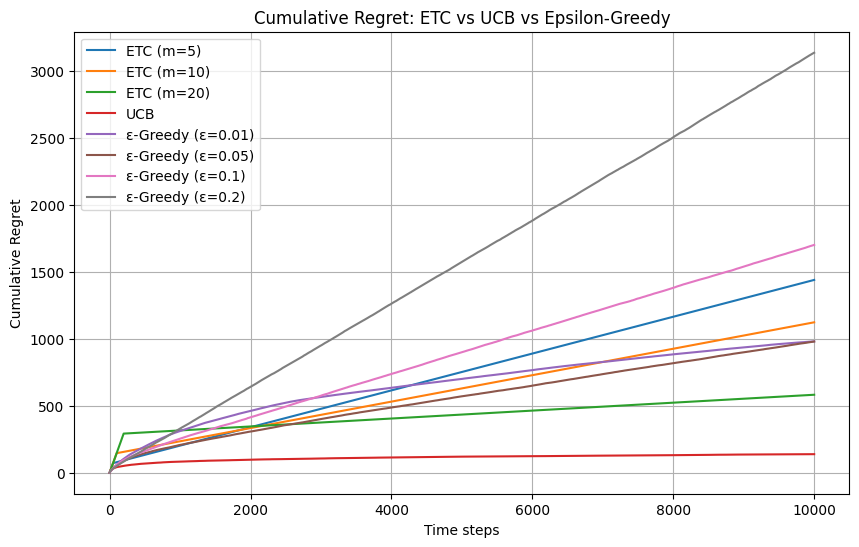

In [18]:
plt.figure(figsize=(10, 6))

# Plot ETC for different m
for m in m_values:
    mean_regret = np.mean(etc_results[m]['regret'], axis=0)
    plt.plot(mean_regret, label=f"ETC (m={m})")

# Add UCB
plt.plot(np.mean(ucb_results['regret'], axis=0), label="UCB")

# Add Epsilon-Greedy
for eps in epsilons:
    plt.plot(np.mean(all_results[eps]['regret'], axis=0), label=f"ε-Greedy (ε={eps})")

plt.xlabel("Time steps")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret: ETC vs UCB vs Epsilon-Greedy")
plt.legend()
plt.grid()
plt.show()


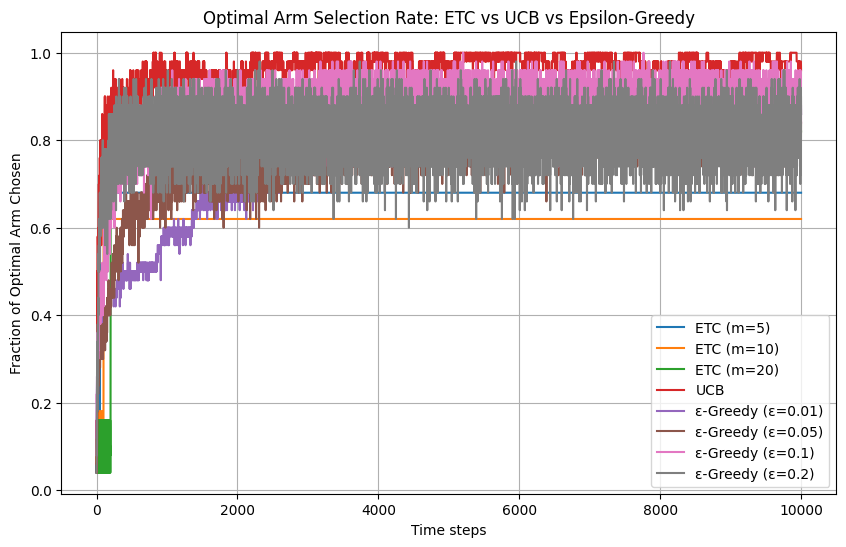

In [19]:
plt.figure(figsize=(10, 6))

# Plot ETC
for m in m_values:
    mean_optimal = np.mean(etc_results[m]['optimal'], axis=0)
    plt.plot(mean_optimal, label=f"ETC (m={m})")

# Add UCB
plt.plot(np.mean(ucb_results['optimal'], axis=0), label="UCB")

# Add Epsilon-Greedy
for eps in epsilons:
    plt.plot(np.mean(all_results[eps]['optimal'], axis=0), label=f"ε-Greedy (ε={eps})")

plt.xlabel("Time steps")
plt.ylabel("Fraction of Optimal Arm Chosen")
plt.title("Optimal Arm Selection Rate: ETC vs UCB vs Epsilon-Greedy")
plt.legend()
plt.grid()
plt.show()


## Botlzmann Exploration

In [20]:
class BoltzmannAgent(BanditAgent):
    def __init__(self, K: int, tau: float):
        super().__init__(K)
        self.tau = tau

    def select_arm(self) -> int:
        if self.tau <= 0:  # Avoid division by zero or negative
            raise ValueError("Temperature τ must be positive.")

        # Compute probabilities using softmax
        exp_values = np.exp(self.values / self.tau)
        probabilities = exp_values / np.sum(exp_values)
        return np.random.choice(self.K, p=probabilities)


In [21]:
tau_values = [0.01, 0.1, 0.5, 1.0, 2.0]  # Different temperature parameters

boltzmann_results = {tau: {'regret': [], 'optimal': []} for tau in tau_values}

print("Running simulations for Boltzmann Exploration")
for tau in tau_values:
    for _ in tqdm(range(num_simulations)):
        bandit = Bandit(K=K, dist_type='gaussian')
        agent = BoltzmannAgent(K=K, tau=tau)
        _, regret, optimal_choices = simulate(bandit, agent, horizon)
        boltzmann_results[tau]['regret'].append(regret)
        boltzmann_results[tau]['optimal'].append(optimal_choices)


Running simulations for Boltzmann Exploration


100%|██████████| 50/50 [00:06<00:00,  7.45it/s]


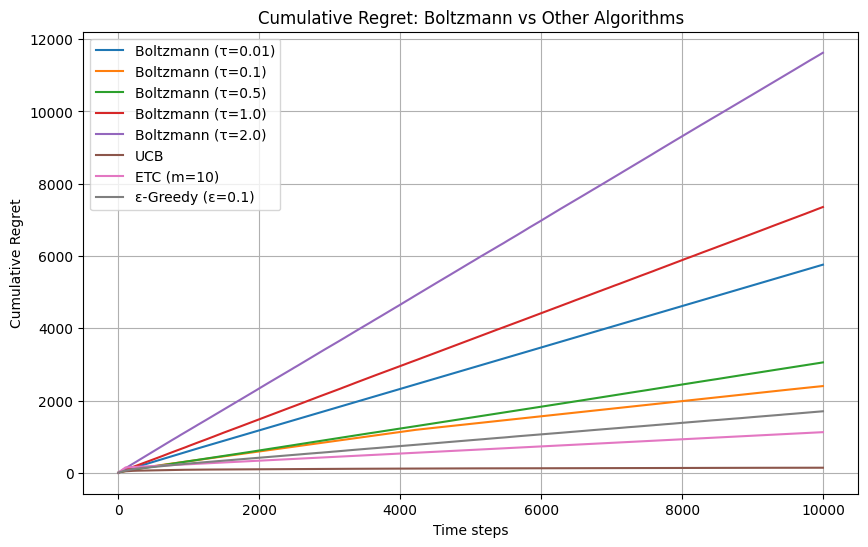

In [22]:
plt.figure(figsize=(10, 6))

# Plot Boltzmann for different tau values
for tau in tau_values:
    mean_regret = np.mean(boltzmann_results[tau]['regret'], axis=0)
    plt.plot(mean_regret, label=f"Boltzmann (τ={tau})")

# Add UCB for comparison
plt.plot(np.mean(ucb_results['regret'], axis=0), label="UCB")

# Add ETC for a fixed m (e.g., m=10)
plt.plot(np.mean(etc_results[10]['regret'], axis=0), label="ETC (m=10)")

# Add Epsilon-Greedy (ε=0.1 as reference)
plt.plot(np.mean(all_results[0.1]['regret'], axis=0), label="ε-Greedy (ε=0.1)")

plt.xlabel("Time steps")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret: Boltzmann vs Other Algorithms")
plt.legend()
plt.grid()
plt.show()


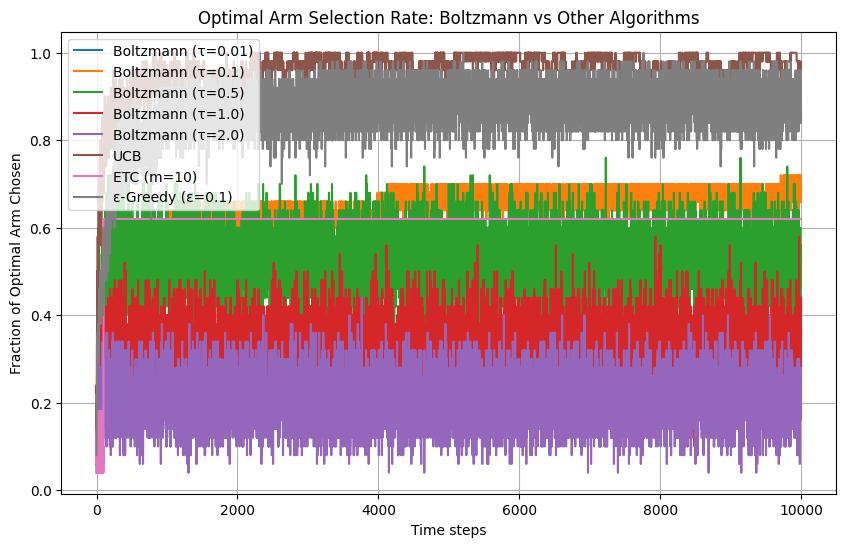

In [23]:
plt.figure(figsize=(10, 6))

# Plot Boltzmann
for tau in tau_values:
    mean_optimal = np.mean(boltzmann_results[tau]['optimal'], axis=0)
    plt.plot(mean_optimal, label=f"Boltzmann (τ={tau})")

# Add UCB
plt.plot(np.mean(ucb_results['optimal'], axis=0), label="UCB")

# Add ETC
plt.plot(np.mean(etc_results[10]['optimal'], axis=0), label="ETC (m=10)")

# Add Epsilon-Greedy (ε=0.1)
plt.plot(np.mean(all_results[0.1]['optimal'], axis=0), label="ε-Greedy (ε=0.1)")

plt.xlabel("Time steps")
plt.ylabel("Fraction of Optimal Arm Chosen")
plt.title("Optimal Arm Selection Rate: Boltzmann vs Other Algorithms")
plt.legend()
plt.grid()
plt.show()


## Policy Gradient

In [24]:
class PolicyGradientAgent:
    def __init__(self, K: int, alpha: float, use_baseline: bool = True):
        self.K = K
        self.alpha = alpha  # Learning rate
        self.theta = np.zeros(K)  # Initialize parameters
        self.use_baseline = use_baseline
        self.baseline = 0.0  # Moving average of rewards
        self.t = 0  # Time step for baseline update

    def select_arm(self) -> int:
        probabilities = self._softmax(self.theta)
        return np.random.choice(self.K, p=probabilities)

    def update(self, chosen_arm: int, reward: float):
        self.t += 1
        probabilities = self._softmax(self.theta)

        # Optional: Baseline for variance reduction
        if self.use_baseline:
            self.baseline += (reward - self.baseline) / self.t
            advantage = reward - self.baseline
        else:
            advantage = reward

        # Gradient ascent update for θ
        grad_log_pi = -probabilities
        grad_log_pi[chosen_arm] += 1  # For chosen arm

        self.theta += self.alpha * advantage * grad_log_pi

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x))  # Stability improvement
        return e_x / np.sum(e_x)


In [25]:
alpha_values = [0.01, 0.05, 0.1]  # Different learning rates

pg_results = {alpha: {'regret': [], 'optimal': []} for alpha in alpha_values}

print("Running simulations for Policy Gradient")
for alpha in alpha_values:
    for _ in tqdm(range(num_simulations)):
        bandit = Bandit(K=K, dist_type='gaussian')
        agent = PolicyGradientAgent(K=K, alpha=alpha)
        _, regret, optimal_choices = simulate(bandit, agent, horizon)
        pg_results[alpha]['regret'].append(regret)
        pg_results[alpha]['optimal'].append(optimal_choices)


Running simulations for Policy Gradient


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


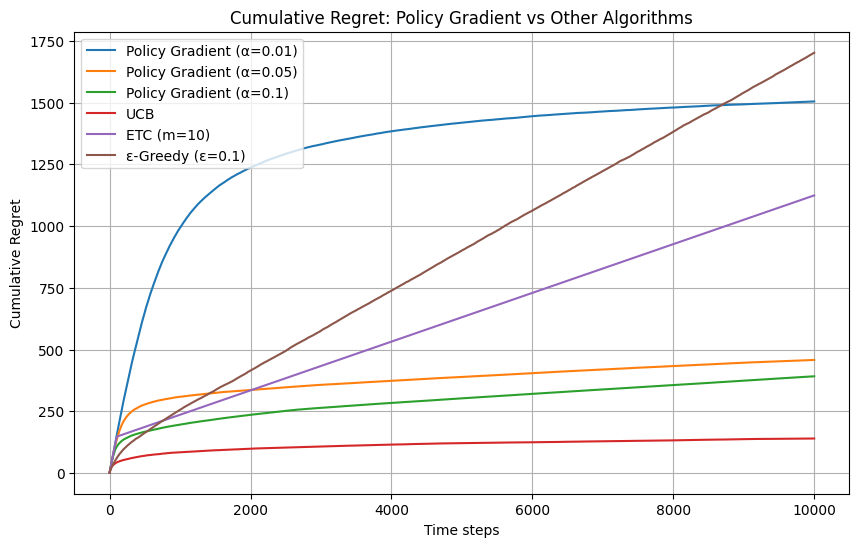

In [26]:
plt.figure(figsize=(10, 6))

# Plot Policy Gradient
for alpha in alpha_values:
    mean_regret = np.mean(pg_results[alpha]['regret'], axis=0)
    plt.plot(mean_regret, label=f"Policy Gradient (α={alpha})")

# Add comparison with UCB, ETC, and Epsilon-Greedy
plt.plot(np.mean(ucb_results['regret'], axis=0), label="UCB")
plt.plot(np.mean(etc_results[10]['regret'], axis=0), label="ETC (m=10)")
plt.plot(np.mean(all_results[0.1]['regret'], axis=0), label="ε-Greedy (ε=0.1)")

plt.xlabel("Time steps")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret: Policy Gradient vs Other Algorithms")
plt.legend()
plt.grid()
plt.show()


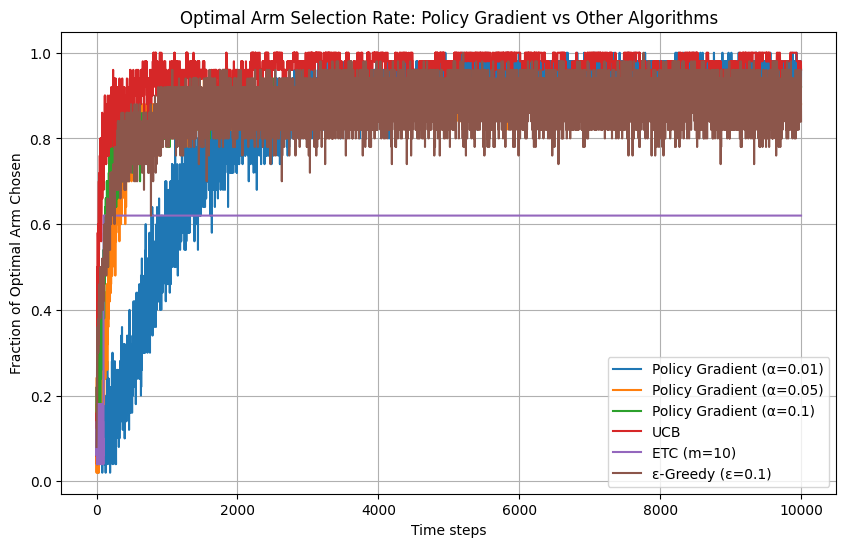

In [27]:
plt.figure(figsize=(10, 6))

# Plot Policy Gradient
for alpha in alpha_values:
    mean_optimal = np.mean(pg_results[alpha]['optimal'], axis=0)
    plt.plot(mean_optimal, label=f"Policy Gradient (α={alpha})")

# Add comparison
plt.plot(np.mean(ucb_results['optimal'], axis=0), label="UCB")
plt.plot(np.mean(etc_results[10]['optimal'], axis=0), label="ETC (m=10)")
plt.plot(np.mean(all_results[0.1]['optimal'], axis=0), label="ε-Greedy (ε=0.1)")

plt.xlabel("Time steps")
plt.ylabel("Fraction of Optimal Arm Chosen")
plt.title("Optimal Arm Selection Rate: Policy Gradient vs Other Algorithms")
plt.legend()
plt.grid()
plt.show()


## Results

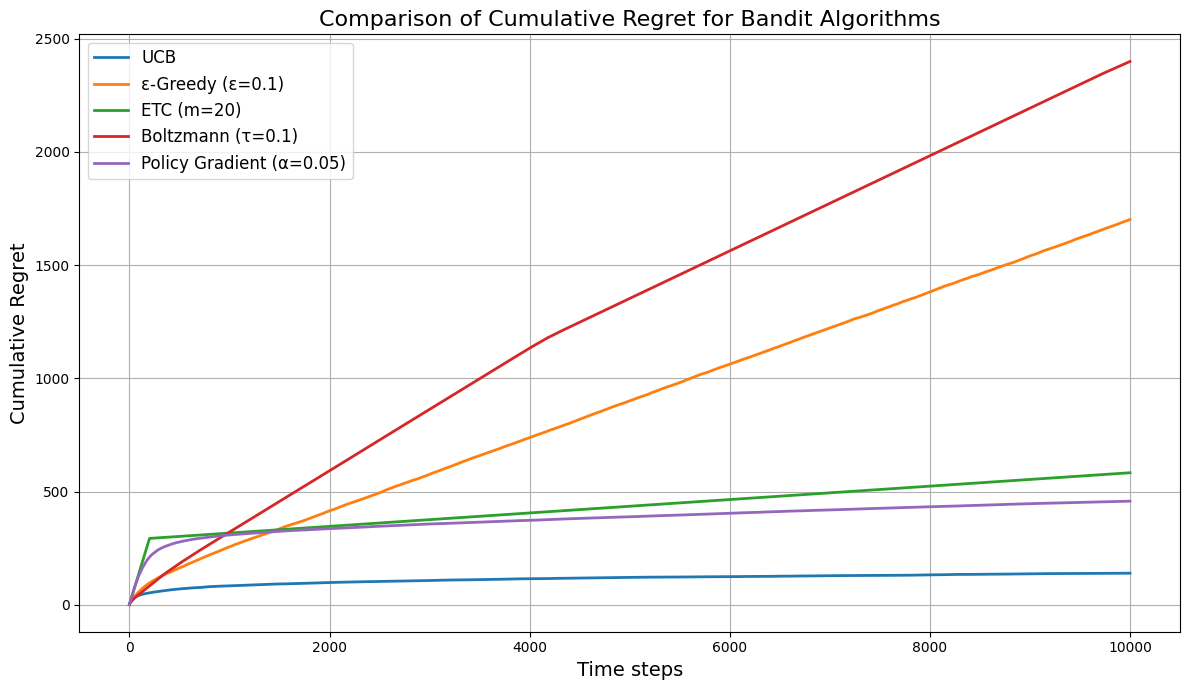

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean regrets for each algorithm
mean_ucb_regret = np.mean(ucb_results['regret'], axis=0)
mean_etc_regret = np.mean(etc_results[20]['regret'], axis=0)  # m=20
mean_eps_regret = np.mean(all_results[0.1]['regret'], axis=0)  # ε=0.1
mean_boltzmann_regret = np.mean(boltzmann_results[0.1]['regret'], axis=0)  # τ=0.5
mean_pg_regret = np.mean(pg_results[0.05]['regret'], axis=0)  # α=0.05

# Plot
plt.figure(figsize=(12, 7))

plt.plot(mean_ucb_regret, label="UCB", linewidth=2)
plt.plot(mean_eps_regret, label="ε-Greedy (ε=0.1)", linewidth=2)
plt.plot(mean_etc_regret, label="ETC (m=20)", linewidth=2)
plt.plot(mean_boltzmann_regret, label="Boltzmann (τ=0.1)", linewidth=2)
plt.plot(mean_pg_regret, label="Policy Gradient (α=0.05)", linewidth=2)

# Aesthetics
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative Regret", fontsize=14)
plt.title("Comparison of Cumulative Regret for Bandit Algorithms", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## Typical regret rates plot

Running simulations...


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


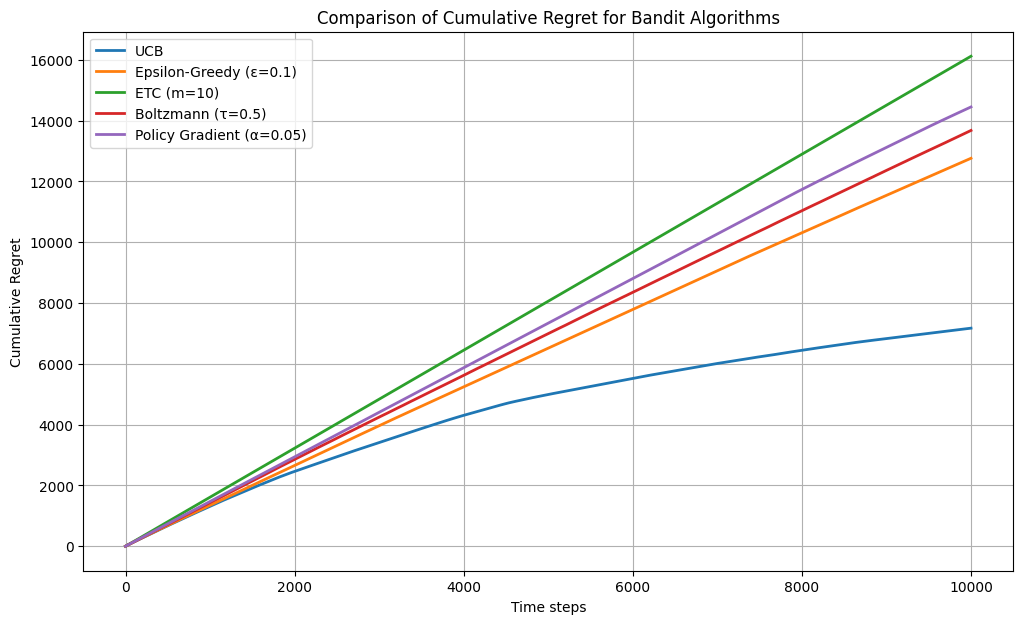

In [30]:
# ---- Simulation Function ----
def simulate(bandit, agent, horizon):
    rewards = np.zeros(horizon)
    regret = np.zeros(horizon)
    optimal_arm = np.argmax(bandit.means)
    optimal_mean = bandit.means[optimal_arm]

    for t in range(horizon):
        arm = agent.select_arm()
        reward = bandit.perform_action(arm)
        agent.update(arm, reward)
        rewards[t] = reward
        regret[t] = optimal_mean - bandit.means[arm]
        if t > 0:
            regret[t] += regret[t - 1]  # Cumulative regret

    return regret

# ---- Running Simulations ----
K = 10
horizon = 10000
num_simulations = 50

agents = {
    "UCB": UCBAgent(K),
    "Epsilon-Greedy (ε=0.1)": EpsilonGreedyAgent(K, epsilon=0.1),
    "ETC (m=10)": ETCAgent(K, m=10, horizon=horizon),
    "Boltzmann (τ=0.5)": BoltzmannAgent(K, tau=0.5),
    "Policy Gradient (α=0.05)": PolicyGradientAgent(K, alpha=0.05)
}

results = {name: [] for name in agents.keys()}

print("Running simulations...")
for name, agent in agents.items():
    for _ in tqdm(range(num_simulations)):
        bandit = Bandit(K=K, dist_type='gaussian')
        regret = simulate(bandit, agent, horizon)
        results[name].append(regret)

# ---- Plotting Results ----
plt.figure(figsize=(12, 7))

for name, regrets in results.items():
    mean_regret = np.mean(regrets, axis=0)
    plt.plot(mean_regret, label=name, linewidth=2)

plt.xlabel("Time steps")
plt.ylabel("Cumulative Regret")
plt.title("Comparison of Cumulative Regret for Bandit Algorithms")
plt.legend()
plt.grid(True)
plt.show()

Running simulations for Optimal Arm Selection Rate...


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


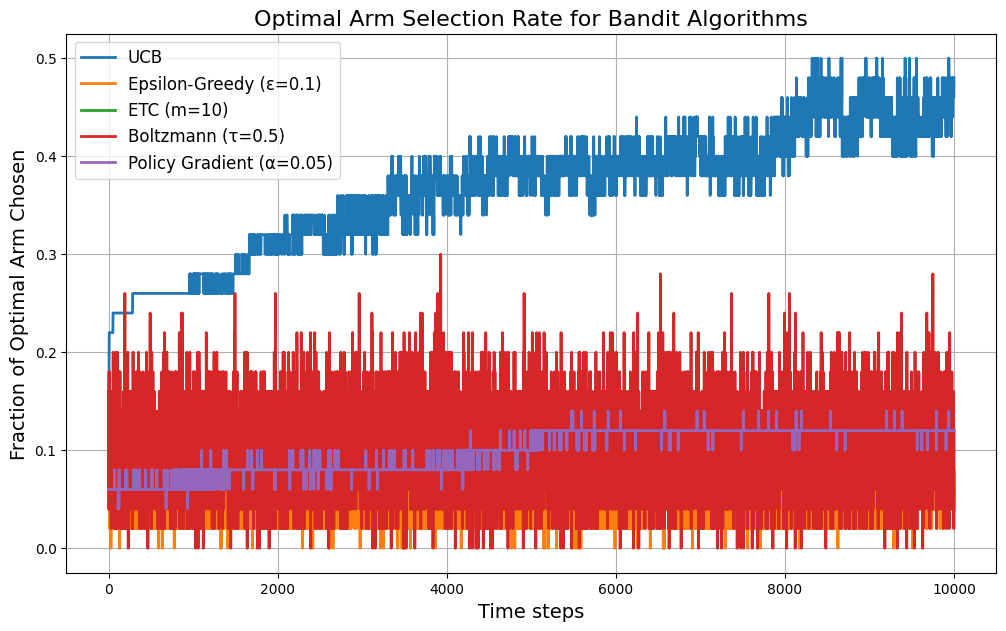

In [31]:
def simulate(bandit, agent, horizon):
    rewards = np.zeros(horizon)
    regret = np.zeros(horizon)
    optimal_choices = np.zeros(horizon)
    
    optimal_arm = np.argmax(bandit.means)
    optimal_mean = bandit.means[optimal_arm]

    for t in range(horizon):
        arm = agent.select_arm()
        reward = bandit.perform_action(arm)
        agent.update(arm, reward)

        rewards[t] = reward
        regret[t] = optimal_mean - bandit.means[arm]
        optimal_choices[t] = 1 if arm == optimal_arm else 0

        if t > 0:
            regret[t] += regret[t - 1]  # Cumulative regret

    return regret, optimal_choices

results_optimal = {name: [] for name in agents.keys()}

print("Running simulations for Optimal Arm Selection Rate...")
for name, agent in agents.items():
    for _ in tqdm(range(num_simulations)):
        bandit = Bandit(K=K, dist_type='gaussian')
        regret, optimal_choices = simulate(bandit, agent, horizon)
        results_optimal[name].append(optimal_choices)

plt.figure(figsize=(12, 7))

for name, optimal_rates in results_optimal.items():
    mean_optimal = np.mean(optimal_rates, axis=0)  # Average across simulations
    plt.plot(mean_optimal, label=name, linewidth=2)

plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Fraction of Optimal Arm Chosen", fontsize=14)
plt.title("Optimal Arm Selection Rate for Bandit Algorithms", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


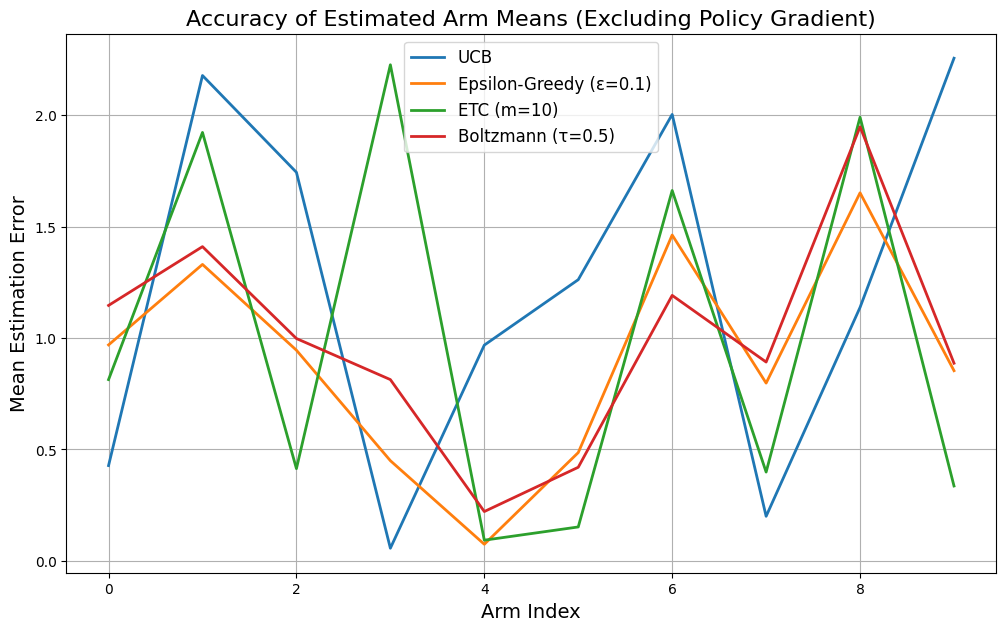

In [34]:
plt.figure(figsize=(12, 7))

for name, agent in agents.items():
    # Exclude Policy Gradient since it does not estimate means
    if isinstance(agent, PolicyGradientAgent):
        continue  

    estimated_means = agent.values  # Get estimated means for algorithms that track values
    true_means = bandit.means  # Get actual means
    error = np.abs(np.array(estimated_means) - np.array(true_means))  # Absolute error
    plt.plot(error, label=name, linewidth=2)

plt.xlabel("Arm Index", fontsize=14)
plt.ylabel("Mean Estimation Error", fontsize=14)
plt.title("Accuracy of Estimated Arm Means (Excluding Policy Gradient)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## Best param simulations

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Update optimal parameters
class EpsilonGreedyOptimal(EpsilonGreedyAgent):
    def __init__(self, K: int):
        """Uses a dynamic, decaying epsilon"""
        super().__init__(K, epsilon=1.0)  # Placeholder value (not used)

    def select_arm(self) -> int:
        """Uses a decaying epsilon: ε_t = 1/t"""
        epsilon_t = 1 / (self.counts.sum() + 1)  # Compute epsilon dynamically
        if np.random.rand() < epsilon_t:
            return np.random.randint(self.K)
        return np.argmax(self.values)


class BoltzmannOptimal(BoltzmannAgent):
    def __init__(self, K: int):
        """Uses a dynamic, decaying temperature"""
        super().__init__(K, tau=1.0)  # Placeholder value, not used

    def select_arm(self) -> int:
        """Uses a decaying temperature: τ_t = 1/log(t)"""
        t = self.counts.sum() + 1
        tau_t = 1 / np.log(t + 1)  # Avoid log(0)
        exp_values = np.exp(self.values / tau_t)
        probabilities = exp_values / np.sum(exp_values)
        return np.random.choice(self.K, p=probabilities)


class PolicyGradientOptimal(PolicyGradientAgent):
    def __init__(self, K: int):
        """Optimized learning rate α = 0.01"""
        super().__init__(K, alpha=0.01)

# Function to estimate ETC's optimal m
def estimate_optimal_m(K, n, sigma=1.0, delta=0.1):
    """Computes the optimal m using the formula m = (4σ²/Δ²) log(nΔ²/4σ²)"""
    return max(1, int(np.ceil((4 * sigma**2 / delta**2) * np.log(n * delta**2 / (4 * sigma**2)))))

# Run simulations
K = 10
horizon = 10000
num_simulations = 50
optimal_m = estimate_optimal_m(K, horizon)

agents_optimal = {
    "UCB": UCBAgent(K),
    "Epsilon-Greedy (ε=1/t)": EpsilonGreedyOptimal(K),
    "ETC (m=optimal)": ETCAgent(K, m=optimal_m, horizon=horizon),
    "Boltzmann (τ=1/log(t))": BoltzmannOptimal(K),
    "Policy Gradient (α=0.01)": PolicyGradientOptimal(K),
}

results_optimal = {name: [] for name in agents_optimal.keys()}
results_rewards = {name: [] for name in agents_optimal.keys()}
results_selection = {name: [] for name in agents_optimal.keys()}

print("Running simulations with optimal parameters...")
for name, agent in agents_optimal.items():
    for _ in tqdm(range(num_simulations)):
        bandit = Bandit(K=K, dist_type='gaussian')
        regret, optimal_choices = simulate(bandit, agent, horizon)
        results_optimal[name].append(regret)
        results_rewards[name].append(np.cumsum(optimal_choices))  # Track cumulative rewards
        results_selection[name].append(optimal_choices)  # Track optimal arm selection


Running simulations with optimal parameters...


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


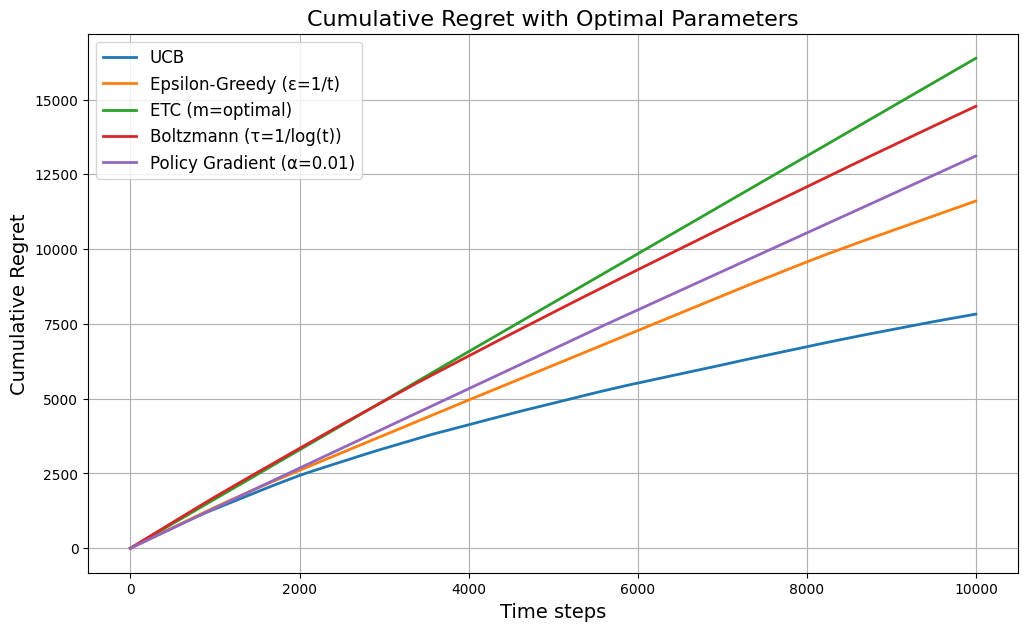

In [40]:
plt.figure(figsize=(12, 7))

for name, regrets in results_optimal.items():
    mean_regret = np.mean(regrets, axis=0)
    plt.plot(mean_regret, label=name, linewidth=2)

plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative Regret", fontsize=14)
plt.title("Cumulative Regret with Optimal Parameters", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


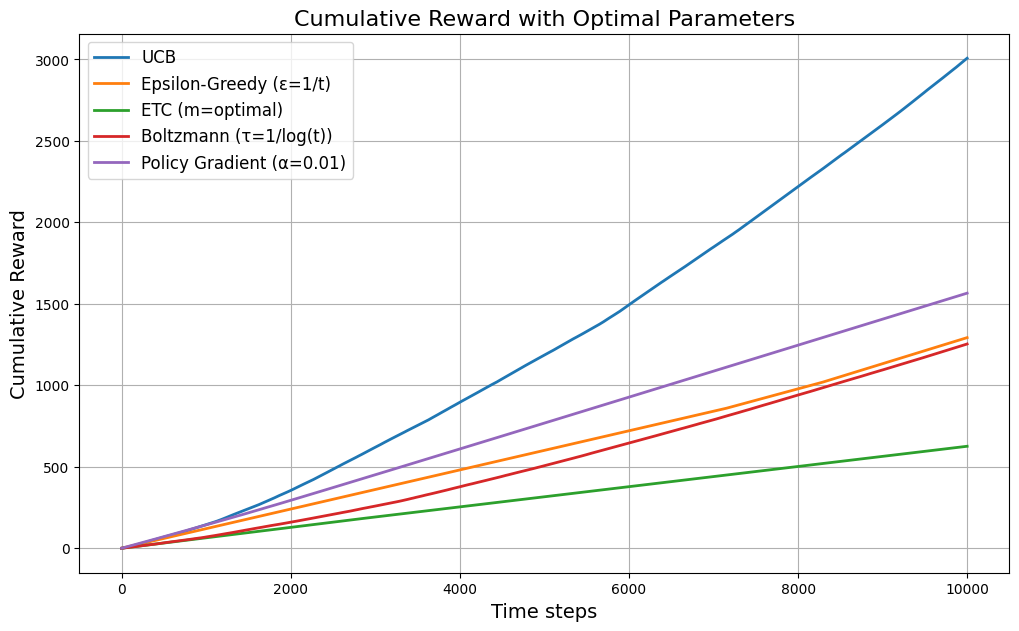

In [38]:
plt.figure(figsize=(12, 7))

for name, rewards in results_rewards.items():
    mean_rewards = np.mean(rewards, axis=0)
    plt.plot(mean_rewards, label=name, linewidth=2)

plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)
plt.title("Cumulative Reward with Optimal Parameters", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


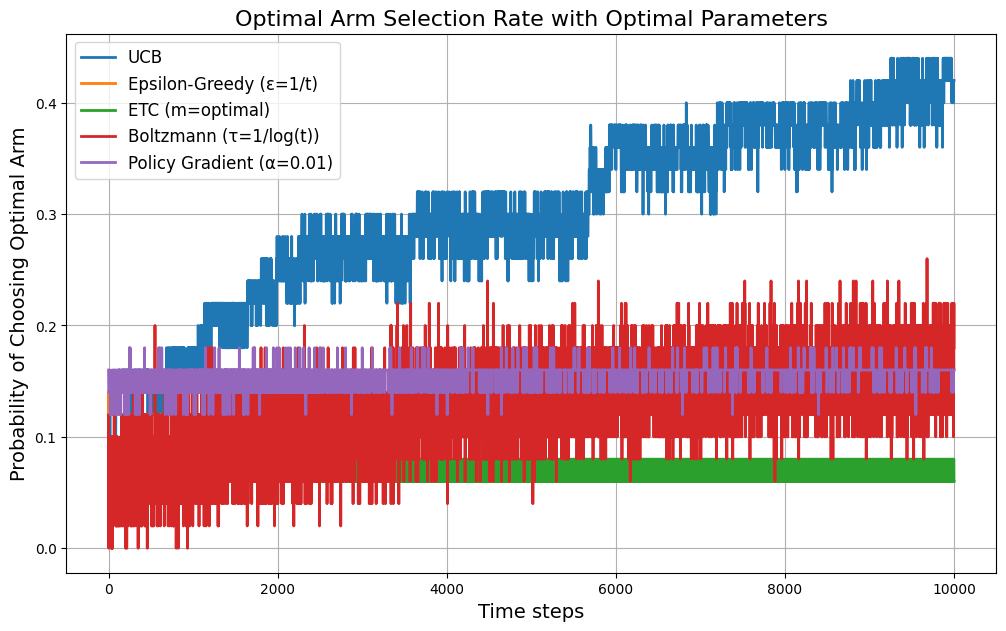

In [39]:
plt.figure(figsize=(12, 7))

for name, optimal_rates in results_selection.items():
    mean_optimal = np.mean(optimal_rates, axis=0)
    plt.plot(mean_optimal, label=name, linewidth=2)

plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Probability of Choosing Optimal Arm", fontsize=14)
plt.title("Optimal Arm Selection Rate with Optimal Parameters", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
